#Image Captioning


In [ ]:
# import necessary packages and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name()) # GPU name

Tesla T4


# Section 1.1 Data
We are gonna use Flickr30k dataset, which consists of 31783 images and 158,915 captions. 



Download dataset

In [ ]:
!kaggle datasets download hsankesara/flickr-image-dataset

100% 8.16G/8.16G [03:07<00:00, 27.8MB/s]
100% 8.16G/8.16G [03:07<00:00, 46.7MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
path_to_homework = "/content/drive/My Drive/DeepLearning/Image_Captioning/"
sys.path.append(path_to_homework)

In [ ]:
from dataloader import Flickr30k, get_loader

# Section 1.2 Take a look at the data

In [ ]:
# visualize images and captions
#print(path_to_homework+'flickr30k_images/')
print('flickr30k_images/')
# flickr = Flickr30k(split='val', root=path_to_homework+'flickr30k_images/')  # load validation set as an example
flickr = Flickr30k(split='val', root='flickr30k_images/')  # load validation set as an example
flickr()

flickr30k_images/
-------flickr30k--------
image root: flickr30k_images/flickr30k_images
dataset split: val
the length of the dataset: 1014


path:  flickr30k_images/flickr30k_images/508838116.jpg
['A woman in a green striped shirt is standing in front of a produce section in a store.', 'A woman in a striped shirt folds her arms while standing in a grocery store.', 'A woman is standing in a very large produce section of a grocery store.', 'A woman in a green striped shirt is in a grocery store.', 'Woman in a produce store looking at strawberries.']


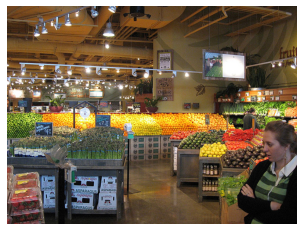

In [ ]:
# show a random image and its captions
img_id = np.random.randint(len(flickr))
img = flickr.get_img(img_id)
captions = flickr.get_captions(img_id)

plt.figure()
plt.imshow(img)
plt.axis('off')

print(captions)

In [ ]:
del flickr

# Section 1.3 Build vocabulary
Build a vocabulary for our dataset. The vocabulary stores all the words and their indices. Use it to embed and recover the words.

In [ ]:
import nltk
import pickle
import json
from tqdm import tqdm
from collections import Counter
nltk.download('punkt') 

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<start>': 2, '<end>': 3}  # follow Pytorch padding rules: pad sentence with zero.
        self.idx = 4
        self.idx2word = {v: k for k, v in self.word2idx.items()}

    def __call__(self, key):
        if key not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[key]

    def __len__(self):
        return len(self.word2idx)

    def add_word(self, word):
        """
        Add new words
        :param word: word
        """
        if word not in self.word2idx:
            self.word2idx[word] = self.idx  # add a new word
            self.idx2word[self.idx] = word
            self.idx += 1

    def reverse(self, value):
        """
        From idx to words.
        :param value: index
        :return:
        """
        if value not in self.idx2word:
            return self.idx2word[1]  # return '<unk>' if the word is unseen before.
        return self.idx2word[value]

def build_vocab(json_file='/flickr30k_images/dataset_flickr30k.json', threshold=3):
    with open(json_file) as f:
            data = json.load(f)
    f.close()
    counter = Counter()
    for img_idx in tqdm(range(len(data['images']))):
        img_annos = data['images'][img_idx]
        for sent_idx in range(len(img_annos['sentids'])):
#             tokens = img_annos['sentences'][sent_idx]['tokens']  # directly load tokens

            caption = img_annos['sentences'][sent_idx]['raw']
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            
            counter.update(tokens)

    # If the number of words is less than threshold we don't count it.
    words = [word for word, cnt in counter.items() if cnt >= threshold]


    # create a Vocabulary class
    vocab = Vocabulary()

    # add words to Vocab
    for i, word in enumerate(words):
        vocab.add_word(word)

    return vocab

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# let's create a vocabulary for future usage
vocab_path = './flickr30k_images/vocab.pkl'
if not os.path.isfile(vocab_path):  # if we don't have vocab, create one
    vocab = build_vocab(json_file='./flickr30k_images/dataset_flickr30k.json', threshold=3)
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))
else:  # if we have, load the existing vocab
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    print('vocab loaded!')
    print('the size of vocab:', len(vocab))
f.close()

100%|██████████| 31014/31014 [00:20<00:00, 1526.67it/s]


Total vocabulary size: 9991
Saved the vocabulary wrapper to './flickr30k_images/vocab.pkl'


In [ ]:
vocab_path = './flickr30k_images/vocab.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
print('vocab loaded!')
print('the size of vocab:', len(vocab))
# print(vocab.word2idx.keys())
# print(vocab.idx2word)

# check some random words
for i in range(3):
    random_idx = np.random.randint(len(vocab))
    print('word: {}, index: {}'.format(list(vocab.word2idx.keys())[random_idx], vocab(list(vocab.word2idx.keys())[random_idx])))

vocab loaded!
the size of vocab: 9991
word: studio, index: 196
word: suburbs, index: 4828
word: ripe, index: 6757


# Section 2 Vanilla RNN 
# Section 2.1 Design the Network: Encoder 
Implement the baseline model by using pre-trained ResNet-50 as the encoder and Vanilla RNN as the decoder. Note that we will remove the last layer (fc layer) of ResNet-50 and add a trainable linear layer to finetune it for our task. During the training, we will **freeze** the layer before the fc layer. The encoder should output a feature vector of a fixed size for each image.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, emb_dim):
        """
        Use ResNet-50 as encoder.
        :param emb_dim: output size of ResNet-50.
        """
        super(Encoder, self).__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        

        # freeze the parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

        # replace the last layer (fc layer) with a trainable layer for finetuning
        layer_list = list(self.resnet.children())[:-1] 
        self.cnn = nn.Sequential(*layer_list)
        D_in = self.resnet.fc.in_features
        #print("D_in", D_in)
        self.linear = nn.Linear(D_in, emb_dim).to(device)
      

    def forward(self, x):
        x = x.to(device)
        # torch.Size([256, 3, 224, 224])

        x = self.cnn(x)  
        #x.shape: torch.Size([256, 2048, 1, 1])


        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)# output shape: [N, emb_dim]
        #x.shape: torch.Size([256, 1024])

        return x
     

# Section 2.2 Design the Network: Decoder 
During decoding, we will train a RNN (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) to learn the structure of the caption text throught "**Teacher Forcing**". Teacher forcing works by using the teaching signal from the training dataset at the current time step, $target(t)$, as input in the next time step $x(t+1) = target(t)$, rather than the output $y(t)$ generated by the network. 

As shown in Figure 1 above, RNN will take three inputs: the *current feature*, hidden state ($h_0$) and cell state ($c_0$). The *current feature* for the first step should be the output of encoder to predict '\<start\>' word. Hidden states for this step should be set to None. Then in the second step '\<start\>' will be passed into RNN as the input, and so on.

To use '\<start\>' or any subsequent word as current feature, get its index from the vocabulary you created, convert it to one-hot vector and pass it through a linear layer to embed into a feature.

For convenience, 'pad' the captions in a mini-batch to convert them into fixed length.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Use RNN as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param num_layers: Number of RNN layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: the probability for dropout.
        """
        super(Decoder, self).__init__()
        self.max_length = 30  # the maximum length of a sentence, in case it's trapped
    
        
        # one-hot encoding + linear layer
        self.embeds = nn.Embedding(vocab_size, emb_dim)
        # vanilla rnn network
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        # output layer
        self.output = nn.Linear(hidden_dim, vocab_size)

        
    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions. Note that you need to pad the input so they have the same length
        :param encode_features: output of encoder, size [N, emb_dim] => [N(batch_size), feature_size(image_encode+embedding), embd_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. size is (batch_size).
        """
        # compute the embedding using one-hot technique and linear function
        embeddings = self.embeds(captions)
        #'pad' the captions in a mini-batch
        
        #print("embeddings.shape", embeddings.shape)
        #embeddings.shape torch.Size([256, 38, 1024])



        # concatenate the encoded features from encoder and embeddings
        #embeddings.shape torch.Size([256, 38, 1024]) + encode_features.shape torch.Size([256, 1024])
        concatenate_features = torch.cat((encode_features.unsqueeze(1), embeddings), dim=1)
        #concatenate_features.shape torch.Size([256, 39, 1024])
        #print("concatenate_features.shape",concatenate_features.shape)

        padded_embeddings = pack_padded_sequence(concatenate_features, lengths, batch_first=True)
        #padded_embeddings.shape torch.Size([3962, 1024])
        #print("padded_embeddings.shape",padded_embeddings.data.shape)

        # feed into RNN.
        rnn_output, hidden_states = self.rnn(padded_embeddings)
        #print("rnn_output.shape: ", rnn_output.data.shape)
        # rnn_output.shape:  torch.Size([3962, 256])

        # output layer
        outputs = self.output(rnn_output.data)
        #print("outputs.shape: ",outputs.shape)
        #outputs.shape:  torch.Size([3962, 9991])

        # hiddens, _ = self.lstm(padded_embeddings)
        # print("hiddens.shape: ",hiddens.data.shape)

        # outputs = self.output(hiddens.data)
        # print("outputs.shape: ",outputs.shape)
        # #outputs.shape:  torch.Size([3962, 9991])

        return outputs

# Encoder-decoder
Put our encoder and decoder together. 

In the sample_generate stage, the idea is to “let the network run on its own”, predicting the next word, and then use the network’s prediction to obtain the next input word. There are at least two ways to obtain the next word.

- **Deterministic**: Take the maximum output at each step.
- **Stochastic**: Sample from the probability distribution. To get the distribution, we need to compute the weighted softmax of the outputs: $y^i = \exp(o^j/\tau) / \sum_n \exp(o^n/\tau)$, where $o^j$ is the output from the last layer, $n$ is the size of the vocabulary, and $\tau$ is the so-called "temperature". 

In [ ]:
class Vanilla_rnn(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Encoder-decoder vanilla RNN.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param num_layers: the number of RNN layers.
        :param dropout: dropout probability
        """
        super(Vanilla_rnn, self).__init__()

   
        # Encoder: ResNet-50
        self.encoder = Encoder(emb_dim)
        # Decoder: RNN
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim, num_layers,dropout)
        self.max_length = self.decoder.max_length
        

    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """
      
        # forward passing
        #print("before encoder.forward")
        features = self.encoder.forward(x)
        
        #print("before decoder.forward")
        outputs = self.decoder.forward(features, captions, lengths)
        #outputs.shape:  torch.Size([3962])

        return outputs

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples during the evaluation.
        
        :param x: input image
        :param states: rnn states
        :param mode: which mode we use.  
         - 'Deterministic': Take the maximum output at each step.
         - 'Stochastic': Sample from the probability distribution from the output layer.
        :param temperature: will be used in the stochastic mode
        :return: sample_idxs. Word indices. We can use vocab to recover the sentence later.
        """
        sample_idxs = []  # record the index of your generated words
        # compute the encoded features
        input_features = self.encoder.forward(x).unsqueeze(1)
        #print("input_features.shape: ", input_features.shape)

        #print("temperature:", temperature)
        #print("mode:", mode)
 
        for i in range(self.max_length):
            outputs, states = self.decoder.rnn(input_features, states)
            # outputs.shape: torch.Size([256, 1, 256])
            # outputs.shape: torch.Size([8, 1, 256])
            #print("outputs.shape:", outputs.shape)

            outputs = self.decoder.output(outputs.squeeze(1))
            # outputs.shape: torch.Size([256, 9991])
            # outputs.shape: torch.Size([8, 9991])
            #print("outputs.shape:", outputs.shape)

            # decide which mode we use
            if mode == 'Deterministic':
                # take the maximum index after the softmax
                _, pred_sample_idx = outputs.max(1)
                  
            elif mode == 'Stochastic':
                #print("outputs.div(temperature).squeeze(0).squeeze(0):",outputs.div(temperature).squeeze(0).squeeze(0).shape)
                # softmax
                probabilities = F.softmax(outputs.div(temperature).squeeze(0).squeeze(0), dim=1)
                # sample from the probability distribution after the softmax
                # Hint: use torch.multinomial() to sample from a distribution.
                #print("probabilities.shape:",probabilities.shape)
                pred_sample_idx = torch.multinomial(probabilities.data, 1).squeeze(1)
            
            #print("pred_sample_idx.shape:", pred_sample_idx.shape)
            #pred_sample_idx.shape: torch.Size([256])
            #print("pred_sample_idx.shape:", pred_sample_idx.shape)
            sample_idxs.append(pred_sample_idx)      
            # update next input as current hidden states 
            input_features = self.decoder.embeds(pred_sample_idx).unsqueeze(1)

        sample_idxs = torch.stack(sample_idxs, 1)                # sampled_ids: (batch_size, max_seq_length)
        #print("sample_idxs.shape: (",len(sample_idxs),",",len(sample_idxs[0]),")")
        # sample_idxs.shape: ( 30 , 256 )

        return sample_idxs

# Section 2.3 Training 
Train your encoder-decoder. You might also want to check the output sentence every epoch.

In [ ]:
# some hyperparameters, you can change them
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 60
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 1024
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + 'checkpoints/rnn/'
os.makedirs(output_dir, exist_ok=True)

## device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark=True

In [ ]:
# Validation
def val(model, data_loader, vocab):
    """
    Inputs:
    :param model: the encoder-decoder network.
    :param data_loader: validation data loader
    :param vocab: pre-built vocabulary
    Output:
    the mean value of validation losses
    """
    print('Validating...')
    val_loss = []
    total_step = len(data_loader)
    criterion = nn.CrossEntropyLoss()

    for itr, (images, captions, lengths) in enumerate(data_loader):

        # forward inputs and compute the validation loss
        images = images.to(device)
        #print("images.shape", images.shape)
        # images.shape torch.Size([8, 3, 224, 224])

        captions = captions.to(device)
        #print("captions.shape", captions.shape)
        # captions.shape torch.Size([8, 20])
        
        val_pred = model.forward(images, captions, lengths)
        #print("val_pred.shape:", val_pred.shape)
        # val_pred.shape: torch.Size([115, 9991])

        val_true = pack_padded_sequence(captions, lengths, batch_first=True).data.to(device) 
        # print("val_true.shape", val_true.shape)
        # val_true.shape torch.Size([115])

        loss = criterion(val_pred, val_true)
        #print("loss:", loss)

        # record the validation loss
        val_loss.append(loss)

        # Print current loss
        if itr % log_step == 0:
            print('Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(itr, total_step, loss.item(), np.exp(loss.item())))
    
    # (optional) you might also want to print out the sentence to see the qualitative performance of your model. 
    # You can use deterministic mode to generate sentences

    #print(val_loss)
    #print("type(val_loss)", type(val_loss))
    val_loss = torch.Tensor(val_loss).data.cpu().numpy()
    #print("type(val_loss)", type(val_loss))

    return np.mean(val_loss)


In [ ]:
# 2. Training code here

print("num_epochs:", num_epochs)

train_data_loader = get_loader(root='./flickr30k_images/', split='train', vocab=vocab, 
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=4)
val_data_loader = get_loader(root='./flickr30k_images/', split='val', vocab=vocab, 
                               transform=transform, batch_size=8, shuffle=True, num_workers=4)

model = Vanilla_rnn(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model

# loss and optimizer
criterion = nn.CrossEntropyLoss()  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

print_image_sample = None
print_caption_sample = None
print_lengths = None

# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
    print('Switch to training...')
    model.train()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):

        # train your model
        image = images.to(device)
        #image.shape: torch.Size([256, 3, 224, 224])

        captions = captions.to(device)
        #print("captions: ",captions[0,:] )
        #captions.shape: torch.Size([256, 38])

        y_pred = model.forward(images, captions, lengths)
        #  y_pred.shape : torch.Size([3962, 9991])
        # print(" y_pred.shape :",y_pred.shape)
        if itr%50 == 0:
            print_image_sample = image
            print_caption_sample = captions

        # record the training loss
        y_true = pack_padded_sequence(captions, lengths, batch_first=True).data.to(device) 
        #print("y_tru.shape: ",y_true.shape)
        #y_tru.shape:  torch.Size([3962])
        loss = criterion(y_pred, y_true)
        #print("the ", itr, "th epoch loss is: ", loss)
        Train_loss_iter.append(loss.data.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print log info
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_rnn.npy'), Train_Losses)  # save the training loss
    
    model.eval()
    # (optional) generate a sample during the training, you can use deterministic mode


    #print("print_image_sample.shape:", print_image_sample.shape)
    sample_idxs = model.sample_generate(print_image_sample).data.cpu().numpy()  # [N, max_length]
    #print("sample_idxs.shape:", sample_idxs.shape)
    #print(sample_idxs)
    for i, sentence in enumerate(sample_idxs):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
    print("generated sentence:", sentence_caption)
    #print(print_caption_sample)
    #print("print_caption_sample.shape:",print_caption_sample.shape)
    for i, sentence in enumerate(print_caption_sample.data.cpu().numpy()):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
    print("ground truth:", sentence_caption)
    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_rnn.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'vanilla_rnn-best.pth'.format(epoch + 1, itr + 1)))

    print()
print('It took: {} s'.format(time.time() - tic))

num_epochs: 60
Start training...
Switch to training...
Epoch [0/60], Step [0/114], Loss: 9.2837, Perplexity: 10760.8154
Epoch [0/60], Step [50/114], Loss: 3.7181, Perplexity: 41.1864
Epoch [0/60], Step [100/114], Loss: 3.6818, Perplexity: 39.7187
generated sentence: a man in a blue shirt is standing in the air .
ground truth: a waterskier performs tricks .
Validating...
Step [0/127], Loss: 3.2289, Perplexity: 25.2524
Step [50/127], Loss: 3.4940, Perplexity: 32.9171
Step [100/127], Loss: 3.7676, Perplexity: 43.2768
updated best val loss: 3.6434233
Save model weights to... /content/drive/My Drive/DeepLearning/Assignment_4/checkpoints/rnn/

Switch to training...
Epoch [1/60], Step [0/114], Loss: 3.4956, Perplexity: 32.9708
Epoch [1/60], Step [50/114], Loss: 3.5988, Perplexity: 36.5534
Epoch [1/60], Step [100/114], Loss: 3.5221, Perplexity: 33.8548
generated sentence: a man in a white shirt is using a rock face .
ground truth: asian buffet style restaurant .
Validating...
Step [0/127], Los

# Section 2.4 Evaluation 

In [ ]:
## evaluation code
from tqdm import tqdm, tqdm_notebook
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoother = SmoothingFunction()

def caption_generator(model, images, vocab, img_ids, captions, mode='Deterministic', temperature=1.0):
    """
    Generate captions.
    :param mode:
    :return:
    """
    sample_idxs = model.sample_generate(images, mode=mode,
                                        temperature=temperature).data.cpu().numpy()  # [N, max_length]
    for i, sentence in enumerate(sample_idxs):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
        captions.append({'caption': sentence_caption})
        # captions.append(sentence_caption)

    return captions

def run_test(model, data_loader, vocab, mode='Deterministic', temperature=1.0):
    """
    Run your model on the test set.
    Inputs:
    :param model: the model you use
    :param data_loader: the data_loader
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    predictions = []
    for itr, (images, captions, lengths) in enumerate(tqdm(data_loader)):
        images = Variable(images).to(device)
        captions = Variable(captions).to(device)
        outputs = model(images, captions, lengths)
        
        img_ids = list(range(itr * data_loader.batch_size, (itr + 1) * data_loader.batch_size))
        predictions = caption_generator(model, images, vocab, img_ids, 
                                        predictions, mode=mode, temperature=temperature)
        
    return predictions

def evaluation(model, vocab, data_path=path_to_homework + './flickr30k_images/', mode='Deterministic', temperature=1.0,
               split='test'):
    """
    Evaluate the performance of your model on the test set using BLEU scores.
    Inputs:
    :param model: the model you use
    :param weight_path: the directory to the weights of your model
    :param vocab: vocabulary
    :param data_path: the directory to the dataset
    :param mode: use 'deterministic' or 'stochastic'
    Outputs:
    :param predictions
    """
    # data loader
    test_data_loader = get_loader(root= './flickr30k_images/', split=split, vocab=vocab, 
                                  transform=transform, batch_size=8, shuffle=False, num_workers=4)
    
    # run your model on the test set
    print('Run on the test set...')
    preds = run_test(model, test_data_loader, vocab, mode, temperature)
    
    # load the groundtruth
    gt = test_data_loader.dataset.annos
    
    # evaluate the performance using BLEU score
    score1 = 0
    score2 = 0
    score3 = 0
    score4 = 0
    
    print('Computing BLEU')
    for itr in tqdm(range(len(gt))):
        candidate = preds[itr]['caption']
        reference = [sent['raw'] for sent in gt[itr]['sentences']]
        score1 += sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoother.method1)
        score2 += sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=smoother.method1)
        score3 += sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=smoother.method1)
        score4 += sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=smoother.method1)
    
    bleu1 = 100 * score1/len(gt)
    bleu2 = 100 * score2/len(gt)
    bleu3 = 100 * score3/len(gt)
    bleu4 = 100 * score4/len(gt)
    
    return bleu1, bleu2, bleu3, bleu4

- Test your outputs in the **Deterministic** way by using BLEU scores. You should at achieve a BLEU 4 of 25.

In [ ]:
## 1. Evaluate the model using BLEU score. Use Deterministic mode.

## Image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Evaluate your model using BLEU score. Use Deterministic mode
model = Vanilla_rnn(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model

model.load_state_dict(torch.load(path_to_homework + 'checkpoints/rnn/vanilla_rnn-best.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 20/1000 [00:00<00:04, 197.75it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:04<00:00, 201.38it/s]

BLEU 1:89.68767687069148, BLEU 2:63.75724619747129, BLEU 3:41.23849656594904, BLEU 4:27.7544551175118


In [ ]:
## 1. Different BLEU score. Use Stochastic mode.

temperature_list = [0.1, 0.2, 0.5, 1.0, 1.5, 2]
bleu_1_list = []
bleu_2_list = []
bleu_3_list = []
bleu_4_list = []

for t in temperature_list:

    ## Image transformation
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            #     transforms.RandomCrop(224, pad_if_needed=True),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))])

    ## Evaluate your model using BLEU score. Use Deterministic mode
    model = Vanilla_rnn(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                      num_layers=1, dropout=dropout).to(device)  # build a model
    model.load_state_dict(torch.load(path_to_homework + '/checkpoints/rnn/vanilla_rnn-best.pth', map_location=torch.device('cpu')))
    model.eval()
    bleu1, bleu2, bleu3, bleu4 = evaluation(model=model, vocab=vocab, mode='Stochastic', temperature=t)
    #bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Stochastic', temperature = temperature)
    print("When temperature = {}, the BLEU scores are: ".format(t))
    print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))
    print()
    bleu_1_list.append(bleu1)
    bleu_2_list.append(bleu2)
    bleu_3_list.append(bleu3)
    bleu_4_list.append(bleu4)
# End of code


  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 19/1000 [00:00<00:05, 181.99it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 194.97it/s]


When temperature = 0.1, the BLEU scores are: 
BLEU 1:81.89315696146839, BLEU 2:55.25552046714226, BLEU 3:35.18167342580643, BLEU 4:23.62596331540676



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 20/1000 [00:00<00:05, 190.51it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 196.52it/s]


When temperature = 0.2, the BLEU scores are: 
BLEU 1:83.89605439423461, BLEU 2:58.73286797923157, BLEU 3:37.21554259851624, BLEU 4:24.945124774384972



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 20/1000 [00:00<00:04, 198.91it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 193.45it/s]


When temperature = 0.5, the BLEU scores are: 
BLEU 1:83.50746560363416, BLEU 2:58.60030432070289, BLEU 3:35.46993787575741, BLEU 4:23.209495450186953



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 16/1000 [00:00<00:06, 153.96it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 184.93it/s]


When temperature = 1.0, the BLEU scores are: 
BLEU 1:81.33658357566746, BLEU 2:53.65031176997367, BLEU 3:26.703377607495685, BLEU 4:14.660267331745398



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 15/1000 [00:00<00:06, 145.53it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:06<00:00, 154.83it/s]


When temperature = 1.5, the BLEU scores are: 
BLEU 1:76.70557442494999, BLEU 2:48.29888786181581, BLEU 3:20.0200835269939, BLEU 4:8.776217123801244



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  1%|          | 12/1000 [00:00<00:08, 111.65it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:08<00:00, 121.60it/s]

When temperature = 2, the BLEU scores are: 
BLEU 1:64.27666007031755, BLEU 2:42.480939246825656, BLEU 3:16.61754360077176, BLEU 4:6.443069215662591



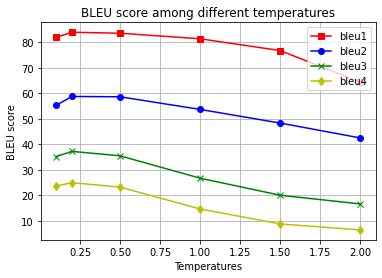

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(temperature_list, bleu_1_list, 's-',color = 'r', label='bleu1')
plt.plot(temperature_list, bleu_2_list, 'o-',color = 'b', label='bleu2')
plt.plot(temperature_list, bleu_3_list, 'x-',color = 'g', label='bleu3')
plt.plot(temperature_list, bleu_4_list, 'd-',color = 'y', label='bleu4')

plt.title('BLEU score among different temperatures')
plt.xlabel('Temperatures')
plt.ylabel('BLEU score')

plt.legend()
plt.grid()
plt.show()

# Section 3 Variations 
## Section 3.1 LSTM 
## Section 3.1.1 Decoder: LSTM
This time, replace the RNN module with an LSTM module.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Use LSTM as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param num_layers: Number of LSTM layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: dropout probability
        """
        super(Decoder, self).__init__()
        self.max_length = 30

        
        # one-hot encoding + linear layer
        self.embeds = nn.Embedding(vocab_size, emb_dim)

        # LSTM network
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        
        # output layer
        self.output = nn.Linear(hidden_dim, vocab_size)


    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions.
        :param encode_features: output of encoder, size [N, emb_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        """

        # compute the embedding using one-hot technique and linear function
        embeddings = self.embeds(captions)
   
        # concatenate the encoded features from encoder and embeddings
        concatenate_features = torch.cat((encode_features.unsqueeze(1), embeddings), dim=1)
        #embeddings.shape torch.Size([256, 38, 1024]) + encode_features.shape torch.Size([256, 1024])
               
        padded_embeddings = pack_padded_sequence(concatenate_features, lengths, batch_first=True)
        #padded_embeddings.shape torch.Size([3962, 1024])

        # feed into LSTM
        lstm_output, hidden_states = self.lstm(padded_embeddings)
        # rnn_output.shape:  torch.Size([3962, 256])        

        # output layer
        outputs = self.output(lstm_output.data)
        #outputs.shape:  torch.Size([3962, 9991])

        return outputs

## Encoder-Decoder

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0):
        """
        Encoder-decoder vanilla RNN.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param num_layers: the number of RNN layers.
        """
        super(LSTM, self).__init__()
        # Encoder: ResNet-50
        self.encoder = Encoder(emb_dim)

        # Decoder: LSTM
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim, num_layers,dropout)
        self.max_length = self.decoder.max_length

    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """

        # forward passing
        features = self.encoder.forward(x)

        outputs = self.decoder.forward(features, captions, lengths)  

        return outputs

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples during the evaluation.
        
        :param x: input image
        :param states: rnn states
        :param mode: which mode we use.  
         - 'Deterministic': Take the maximum output at each step.
         - 'Stochastic': Sample from the probability distribution from the output layer.
        :param temperature: will be used in the stochastic mode
        :return: sample_idxs. Word indices. We can use vocab to recover the sentence.
        """
        sample_idxs = []

        # compute the encoded features
        input_features = self.encoder.forward(x).unsqueeze(1)

        for i in range(self.max_length):
            # LSTM layer 
            outputs, states = self.decoder.lstm(input_features, states)

            # FC layer
            outputs = self.decoder.output(outputs.squeeze(1))
            #outputs.shape: torch.Size([256, 9991])

            pred_sample_idx = None
            # decide which mode we use
            if mode == 'Deterministic':
                _, pred_sample_idx = outputs.max(1)
                
            elif mode == 'Stochastic':
                probabilities = F.softmax(outputs.div(temperature).squeeze(0).squeeze(0), dim=1)
                # sample from the probability distribution after the softmax
                pred_sample_idx = torch.multinomial(probabilities.data, 1).squeeze(1)
                        
            # record predicted result idx
            sample_idxs.append(pred_sample_idx)    
            # update next input as current hidden states 
            input_features = self.decoder.embeds(pred_sample_idx).unsqueeze(1)

        sample_idxs = torch.stack(sample_idxs, 1)   
        
        return sample_idxs

## Section 3.1.2 Training 
Use the same set of hyper-parameters (hidden units, optimizer, learning rate etc.) for both models.

In [ ]:
# some hyperparameters
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 60
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 1024
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + 'checkpoints/lstm/'
os.makedirs(output_dir, exist_ok=True)


In [ ]:
# Training code here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark=True

train_data_loader = get_loader(root='./flickr30k_images/', split='train', vocab=vocab,
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = get_loader(root='./flickr30k_images/', split='val', vocab=vocab,
                             transform=transform, batch_size=8, shuffle=True, num_workers=4)

model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

print_image_sample = None
print_caption_sample = None


# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
    print('Switch to training...')
    model.train()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):
        ########Your Code###########
        # train your model
        image = images.to(device)
        captions = captions.to(device)

        y_pred = model.forward(images, captions, lengths)

        # record one sample to print for each epoch
        if itr%50 == 0:
            print_image_sample = image
            print_caption_sample = captions 
          
        # record the training loss
        y_true = pack_padded_sequence(captions, lengths, batch_first=True).data.to(device) 
        loss = criterion(y_pred, y_true)

        Train_loss_iter.append(loss.data.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()         
        
        # print log info
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    #print("Average training loss : ", np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_lstm.npy'), Train_Losses)  # save the training loss
    
    model.eval()


    #print("print_image_sample.shape:", print_image_sample.shape)
    sample_idxs = model.sample_generate(print_image_sample).data.cpu().numpy()  
    #print("sample_idxs.shape:", sample_idxs.shape)
    #print(sample_idxs)
    #print(sample_idxs)
    for i, sentence in enumerate(sample_idxs):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
    print("generated sentence:", sentence_caption)

    for i, sentence in enumerate(print_caption_sample.data.cpu().numpy()):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
    print("ground truth:", sentence_caption)

    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_lstm.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'lstm-best.pth'.format(epoch + 1, itr + 1)))
    print()
print('It took: {} s'.format(time.time() - tic))

Start training...
Switch to training...
Epoch [0/60], Step [0/114], Loss: 9.2046, Perplexity: 9943.0485
Epoch [0/60], Step [50/114], Loss: 3.6260, Perplexity: 37.5621
Epoch [0/60], Step [100/114], Loss: 3.4544, Perplexity: 31.6394
generated sentence: a man in a blue shirt and a black shirt is standing in front of a crowd of people .
ground truth: a chinese festival .
Validating...
Step [0/127], Loss: 3.7965, Perplexity: 44.5469
Step [50/127], Loss: 3.1251, Perplexity: 22.7620
Step [100/127], Loss: 2.9132, Perplexity: 18.4159
updated best val loss: 3.3540506
Save model weights to... /content/drive/My Drive/DeepLearning/Assignment_4/checkpoints/lstm/

Switch to training...
Epoch [1/60], Step [0/114], Loss: 3.3009, Perplexity: 27.1374
Epoch [1/60], Step [50/114], Loss: 3.1908, Perplexity: 24.3078
Epoch [1/60], Step [100/114], Loss: 3.1839, Perplexity: 24.1401
generated sentence: a man in a blue shirt and a blue shirt is holding a baby .
ground truth: a rock climber 
Validating...
Step [0/

## Section 3.1.3 Evalution
Evaluate model on the test set by perplexity score or BLEU score

In [ ]:
## Evaluate model using BLEU score. Use Deterministic mode.

## Image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Evaluate model using BLEU score. Use Deterministic mode
model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                   num_layers=1, dropout=dropout).to(device)  # build a model

model.load_state_dict(torch.load(path_to_homework + 'checkpoints/lstm/lstm-best_60_1102.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 17/1000 [00:00<00:05, 168.57it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 195.23it/s]

BLEU 1:91.06904090407103, BLEU 2:61.81292484848491, BLEU 3:37.4671764946456, BLEU 4:25.460638566101693


In [ ]:

temperature_list = [0.1, 0.2, 0.5, 1.0, 1.5, 2]
lstm_bleu_1_list = []
lstm_bleu_2_list = []
lstm_bleu_3_list = []
lstm_bleu_4_list = []

for t in temperature_list:

    ## Image transformation
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            #     transforms.RandomCrop(224, pad_if_needed=True),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))])

    ## Evaluate your model using BLEU score. Use Deterministic mode
    model = LSTM(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, 
                      num_layers=1, dropout=dropout).to(device)  # build a model
    model.load_state_dict(torch.load(path_to_homework + '/checkpoints/lstm/lstm-best_60_1102.pth', map_location=torch.device('cpu')))
    model.eval()
    bleu1, bleu2, bleu3, bleu4 = evaluation(model=model, vocab=vocab, mode='Stochastic', temperature=t)
    #bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Stochastic', temperature = temperature)
    print("When temperature = {}, the BLEU scores are: ".format(t))
    print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))
    print()
    lstm_bleu_1_list.append(bleu1)
    lstm_bleu_2_list.append(bleu2)
    lstm_bleu_3_list.append(bleu3)
    lstm_bleu_4_list.append(bleu4)
# End of code

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 20/1000 [00:00<00:04, 197.54it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 196.94it/s]


When temperature = 0.1, the BLEU scores are: 
BLEU 1:88.96274092731322, BLEU 2:61.745842751061765, BLEU 3:38.06160641035131, BLEU 4:25.712864173014513



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 21/1000 [00:00<00:04, 202.40it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 199.69it/s]


When temperature = 0.2, the BLEU scores are: 
BLEU 1:87.29339867034274, BLEU 2:61.08740783195924, BLEU 3:37.850095658545264, BLEU 4:25.685840667688918



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 20/1000 [00:00<00:04, 199.74it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 195.21it/s]


When temperature = 0.5, the BLEU scores are: 
BLEU 1:85.43423342812106, BLEU 2:59.96181526868622, BLEU 3:35.64560540549016, BLEU 4:23.017840650379668



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 18/1000 [00:00<00:05, 174.07it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 186.23it/s]


When temperature = 1.0, the BLEU scores are: 
BLEU 1:82.9421142271436, BLEU 2:54.06042372979603, BLEU 3:26.603325343635262, BLEU 4:14.420963163452997



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 17/1000 [00:00<00:06, 158.06it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:06<00:00, 160.23it/s]


When temperature = 1.5, the BLEU scores are: 
BLEU 1:77.56119097458078, BLEU 2:48.608866442617234, BLEU 3:19.893434112781602, BLEU 4:8.738569615235065



  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  1%|          | 12/1000 [00:00<00:08, 116.91it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:07<00:00, 126.03it/s]

When temperature = 2, the BLEU scores are: 
BLEU 1:66.99476233414111, BLEU 2:43.48490365971332, BLEU 3:16.783703620245493, BLEU 4:6.558492970077838



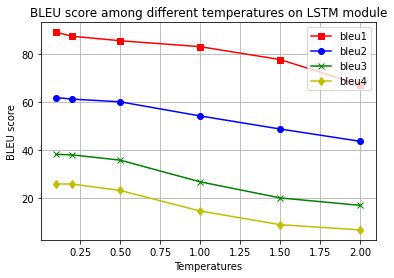

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(temperature_list, lstm_bleu_1_list, 's-',color = 'r', label='bleu1')
plt.plot(temperature_list, lstm_bleu_2_list, 'o-',color = 'b', label='bleu2')
plt.plot(temperature_list, lstm_bleu_3_list, 'x-',color = 'g', label='bleu3')
plt.plot(temperature_list, lstm_bleu_4_list, 'd-',color = 'y', label='bleu4')

plt.title('BLEU score among different temperatures on LSTM module')
plt.xlabel('Temperatures')
plt.ylabel('BLEU score')

plt.legend()
plt.grid()
plt.show()

## Section 3.2 Using pre-trained word embeddings
For now, the decoder uses a word as input by converting it into a fixed size embedding, and our networks learn these word embeddings by training. In this experiment, use pre-trained word embeddings like Word2Vec or GloVe in LSTM. 

Some embedding resources:
- GloVe: https://nlp.stanford.edu/projects/glove/
- Word2Vec: http://jalammar.github.io/illustrated-word2vec/


## Section 3.2.1 Encoder-decoder 

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pretrained_emb, num_layers=1, dropout=0):
        """
        Use LSTM as decoder for captions.
        :param emb_dim: Embedding dimensions.
        :param hidden_dim: Hidden states dimensions.
        :param pretrained_emb: the path to the pretrained embedding
        :param num_layers: Number of LSTM layers.
        :param vocab_size: The size of Vocabulary.
        :param dropout: dropout probability
        """
        super(Decoder, self).__init__()
        self.max_length = 30  # in case it's trapped

        # load pre-trained embedding weights and freeze this layer
        weights = torch.from_numpy(np.load(pretrained_emb))
        weights = weights.to(torch.float32)
        self.embeds = nn.Embedding.from_pretrained(weights, freeze=True)

        # lstm network
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        
        # output layer
        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, encode_features, captions, lengths):
        """
        Feed forward to generate captions.
        :param encode_features: output of encoder, size [N, emb_dim]
        :param captions: captions, size [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        """

        # compute the embedding using one-hot technique and linear function
        embeddings = self.embeds(captions)

        # concatenate the encoded features from encoder and embeddings
        concatenate_features = torch.cat((encode_features.unsqueeze(1), embeddings), dim=1)
        padded_embeddings = pack_padded_sequence(concatenate_features, lengths, batch_first=True)

        # feed into RNN
        lstm_output, hidden_states = self.lstm(padded_embeddings)  


        # output layer
        outputs = self.output(lstm_output.data)

        
        return outputs

In [ ]:
class Word_embeddings(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pretrained_emb, num_layers=1, dropout=0):
        """
        Encoder-decoder baseline.
        :param vocab_size: the size of Vocabulary.
        :param emb_dim: the dimensions of word embedding.
        :param hidden_dim: the dimensions of hidden units.
        :param pretrained_emb: the path to the pretrained embedding
        :param num_layers: the number of LSTM layers.
        :param dropout: dropout probability.
        """
        super(Word_embeddings, self).__init__()

        # Encoder: ResNet-50
        self.encoder = Encoder(emb_dim)

        # Decoder: LSTM
        self.decoder = Decoder(vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=hidden_dim, pretrained_emb=pretrained_emb)
        self.max_length = self.decoder.max_length

        

    def forward(self, x, captions, lengths):
        """
        Feed forward.
        :param x: Images, [N, 3, H, W]
        :param captions: encoded captions, [N, max(lengths)]
        :param lengths: a list indicating valid length for each caption. length is (batch_size).
        :return: output logits, usually followed by a softmax layer.
        """

        # forward passing
        features = self.encoder.forward(x)
        x = self.decoder.forward(features, captions, lengths) 

        return x

    def sample_generate(self, x, states=None, mode='Deterministic', temperature=5.0):
        """
        Generate samples.
        :param x:
        :return:
        """
        sample_idxs = []

        # compute the encoded features
        input_features = self.encoder.forward(x).unsqueeze(1)

        for i in range(self.max_length):
            # LSTM layer 
            outputs, states = self.decoder.lstm(input_features, states)

            # FC layer
            outputs = self.decoder.output(outputs.squeeze(1))
            #print("outputs.shape:",outputs.shape)

            pred_sample_idx = None
            # decide which mode we use
            if mode == 'Deterministic':
                _, pred_sample_idx = outputs.max(1)
                
            elif mode == 'Stochastic':
                probabilities = F.softmax(outputs.div(temperature).squeeze(0).squeeze(0), dim=1)
                # sample from the probability distribution after the softmax
                pred_sample_idx = torch.multinomial(probabilities.data, 1).squeeze(1)
                        
            # record predicted result idx
            #print("pred_sample_idx.shape:", pred_sample_idx.shape)
            sample_idxs.append(pred_sample_idx)    
            # update next input as current hidden states 
            input_features = self.decoder.embeds(pred_sample_idx).unsqueeze(1)

        sample_idxs = torch.stack(sample_idxs, 1)   
        #print("sample_idxs.shape: (",len(sample_idxs),",",len(sample_idxs[0]),")")
        
        return sample_idxs

## Section 3.2.2 Training 



In [ ]:
# some hyperparameters
## training parameters
batch_size = 256
lr = 1e-2
num_epochs = 50
weight_decay = 0.0
log_step = 50

## network architecture
emb_dim = 300
hidden_dim = 256
num_layers = 1 # number of RNN layers
dropout = 0.0

## image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Output directory
output_dir = path_to_homework + '/checkpoints/pretrained_emb/'
os.makedirs(output_dir, exist_ok=True)

# pretrained embedding weights
pre_emb_path = path_to_homework+'wm_06.npy' 

In [ ]:
# Training code here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark=True

train_data_loader = get_loader(root='./flickr30k_images/', split='train', vocab=vocab,
                               transform=transform, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = get_loader(root='./flickr30k_images/', split='val', vocab=vocab,
                             transform=transform, batch_size=8, shuffle=True, num_workers=4)

# pretrained embedding weights
pre_emb_path = path_to_homework+'wm_06.npy'  # type the path to the pretrained embedding you find

model = Word_embeddings(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, pretrained_emb=pre_emb_path,
                   num_layers=1, dropout=dropout).to(device)  # build a model

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # CE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=5,
                                      gamma=0.5)  # decay LR by a factor of 0.5 every 10 epochs. You can change this

# logs
Train_Losses = []  # record average training loss each epoch
Val_Losses = []   # record average validation loss each epoch
total_step = len(train_data_loader)  # number of iterations each epoch
best_val_loss = np.inf

print_image_sample = None
print_caption_sample = None

# start training
print('Start training...')
import time
tic = time.time()
for epoch in range(num_epochs):
    print('Switch to training...')
    model.train()
    Train_loss_iter = []  # record the the training loss each iteration
    for itr, (images, captions, lengths) in enumerate(train_data_loader):
 
        # train your model
        image = images.to(device)
        captions = captions.to(device)

        y_pred = model.forward(images, captions, lengths)

        # record one sample to print for each epoch
        if itr%50 == 0:
            print_image_sample = image
            print_caption_sample = captions       

        # record the training loss
        y_true = pack_padded_sequence(captions, lengths, batch_first=True).data.to(device) 
        loss = criterion(y_pred, y_true)

        Train_loss_iter.append(loss.data.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        
        # print log info
        if itr % log_step == 0:
            # print current loss and perplexity
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, itr, total_step, loss.item(), np.exp(loss.item())))
    scheduler.step()
    Train_Losses.append(np.mean(Train_loss_iter))
    np.save(os.path.join(output_dir, 'TrainingLoss_pretrain.npy'), Train_Losses)  # save the training loss
    
    model.eval()

    
    #print("print_image_sample.shape:", print_image_sample.shape)
    sample_idxs = model.sample_generate(print_image_sample).data.cpu().numpy()  
    #print("sample_idxs.shape:", sample_idxs.shape)
    for i, sentence in enumerate(sample_idxs):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
    print("generated sentence:", sentence_caption)

    for i, sentence in enumerate(print_caption_sample.data.cpu().numpy()):  # every sentence in this batch
        sentence_caption = ''
        for word_idx in sentence:
            word = vocab.idx2word[word_idx]
            if word != '<start>' and word != '<end>':
                if word == '.':
                    sentence_caption += '.'
                else:
                    sentence_caption += word + ' '
            if word == '<end>':
                break
    print("ground truth:", sentence_caption)
    
    # validation
    Val_Losses.append(val(model, val_data_loader, vocab))
    np.save(os.path.join(output_dir, 'ValLoss_pretrain.npy'), Val_Losses) # save the val loss
    
    # save model
    if Val_Losses[-1] < best_val_loss:
        best_val_loss = Val_Losses[-1]
        print('updated best val loss:', best_val_loss)
        print('Save model weights to...', output_dir)
        torch.save(model.state_dict(), 
                   os.path.join(output_dir, 'pretrain-best.pth'.format(epoch + 1, itr + 1)))

    print()
print('It took: {} s'.format(time.time() - tic))

Start training...
Switch to training...
Epoch [0/50], Step [0/114], Loss: 9.2148, Perplexity: 10045.1737
Epoch [0/50], Step [50/114], Loss: 3.5826, Perplexity: 35.9657
Epoch [0/50], Step [100/114], Loss: 3.2732, Perplexity: 26.3966
generated sentence: a man in a blue shirt is standing on a bench .
ground truth: the girl swings .
Validating...
Step [0/127], Loss: 2.6936, Perplexity: 14.7851
Step [50/127], Loss: 3.0290, Perplexity: 20.6764
Step [100/127], Loss: 3.4905, Perplexity: 32.8036
updated best val loss: 3.2730348
Save model weights to... /content/drive/My Drive/DeepLearning/Assignment_4/checkpoints/pretrained_emb/

Switch to training...
Epoch [1/50], Step [0/114], Loss: 3.3111, Perplexity: 27.4148
Epoch [1/50], Step [50/114], Loss: 3.2258, Perplexity: 25.1725
Epoch [1/50], Step [100/114], Loss: 3.0385, Perplexity: 20.8744
generated sentence: a man in a white shirt and a black shirt is sitting on a bench .
ground truth: two jockeys race horses 
Validating...
Step [0/127], Loss: 3.

## Section 3.2.3 Evaluation

In [ ]:
## Evaluate model using BLEU score. Use Deterministic mode

## Image transformation
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #     transforms.RandomCrop(224, pad_if_needed=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

## Evaluate model using BLEU score. Use Deterministic mode
model = Word_embeddings(vocab_size=len(vocab), emb_dim=emb_dim, hidden_dim=hidden_dim, pretrained_emb=pre_emb_path,
                   num_layers=1, dropout=dropout).to(device)  # build a model

model.load_state_dict(torch.load(path_to_homework + 'checkpoints/pretrained_emb/pretrain-best.pth', map_location=torch.device('cpu')))
model.eval()
bleu1, bleu2, bleu3, bleu4 = evaluation(model, vocab, mode='Deterministic')
print("BLEU 1:{}, BLEU 2:{}, BLEU 3:{}, BLEU 4:{}".format(bleu1, bleu2, bleu3, bleu4))

  0%|          | 0/125 [00:00<?, ?it/s]

Run on the test set...


  2%|▏         | 17/1000 [00:00<00:05, 169.66it/s]

Computing BLEU


100%|██████████| 1000/1000 [00:05<00:00, 192.44it/s]

BLEU 1:91.83305134251394, BLEU 2:64.46125911173951, BLEU 3:38.56207609627416, BLEU 4:25.885876537221964
